<a href="https://colab.research.google.com/github/prathambansal-swaja/Speech_recog/blob/main/Speech_recognition_sample_docs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q tensorflow tensorflow_datasets

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from keras import layers
from keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
# DATASET_PATH = '/content/data/mini_speech_commands_extracted/mini_speech_commands'

# data_dir = pathlib.Path(DATASET_PATH)
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#       'mini_speech_commands.zip',
#       origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
#       extract=True,
#       cache_dir='.', cache_subdir='data')

In [6]:
import pathlib
import tensorflow as tf

DATASET_PATH = '/content/data/speech_commands_v0_extracted'

data_dir = pathlib.Path(DATASET_PATH)

if not data_dir.exists():
    tf.keras.utils.get_file(
        fname='speech_commands_v0.01.tar.gz',
        origin="http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz",
        extract=True,
        cache_dir='.',
        cache_subdir='data'
    )


In [7]:
# commands = np.array(tf.io.gfile.listdir(str(data_dir)))
# commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
# print('Commands:', commands)

Commands: ['eight' 'zero' 'go' 'bed' 'house' 'two' 'happy' 'one' 'seven' 'on'
 'three' 'left' 'no' 'bird' 'five' 'four' 'wow' 'stop' 'nine' 'LICENSE'
 '_background_noise_' 'six' 'tree' 'up' 'yes' 'down' 'marvin' 'dog'
 'sheila' 'right' 'validation_list.txt' 'cat' 'off' 'testing_list.txt']


In [12]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

remove_items = ['README.md', '.DS_Store', 'LICENSE', 'validation_list.txt', 'testing_list.txt','_background_noise_']

commands = np.array([c for c in commands if c not in remove_items])

print("Commands:", commands)


Commands: ['eight' 'zero' 'go' 'bed' 'house' 'two' 'happy' 'one' 'seven' 'on'
 'three' 'left' 'no' 'bird' 'five' 'four' 'wow' 'stop' 'nine' 'six' 'tree'
 'up' 'yes' 'down' 'marvin' 'dog' 'sheila' 'right' 'cat' 'off']


In [13]:
allowed_commands = [
    'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy',
    'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right',
    'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero'
]
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both',
    class_names=allowed_commands )

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 64721 files belonging to 30 classes.
Using 51777 files for training.
Using 12944 files for validation.

label names: ['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes' 'zero']


# **The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of (batch, samples, channels).**

In [14]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

*This dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis:*

In [15]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [16]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [17]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [18]:
label_names[[1,1,3,0]]

array(['bird', 'bird', 'dog', 'bed'], dtype='<U6')

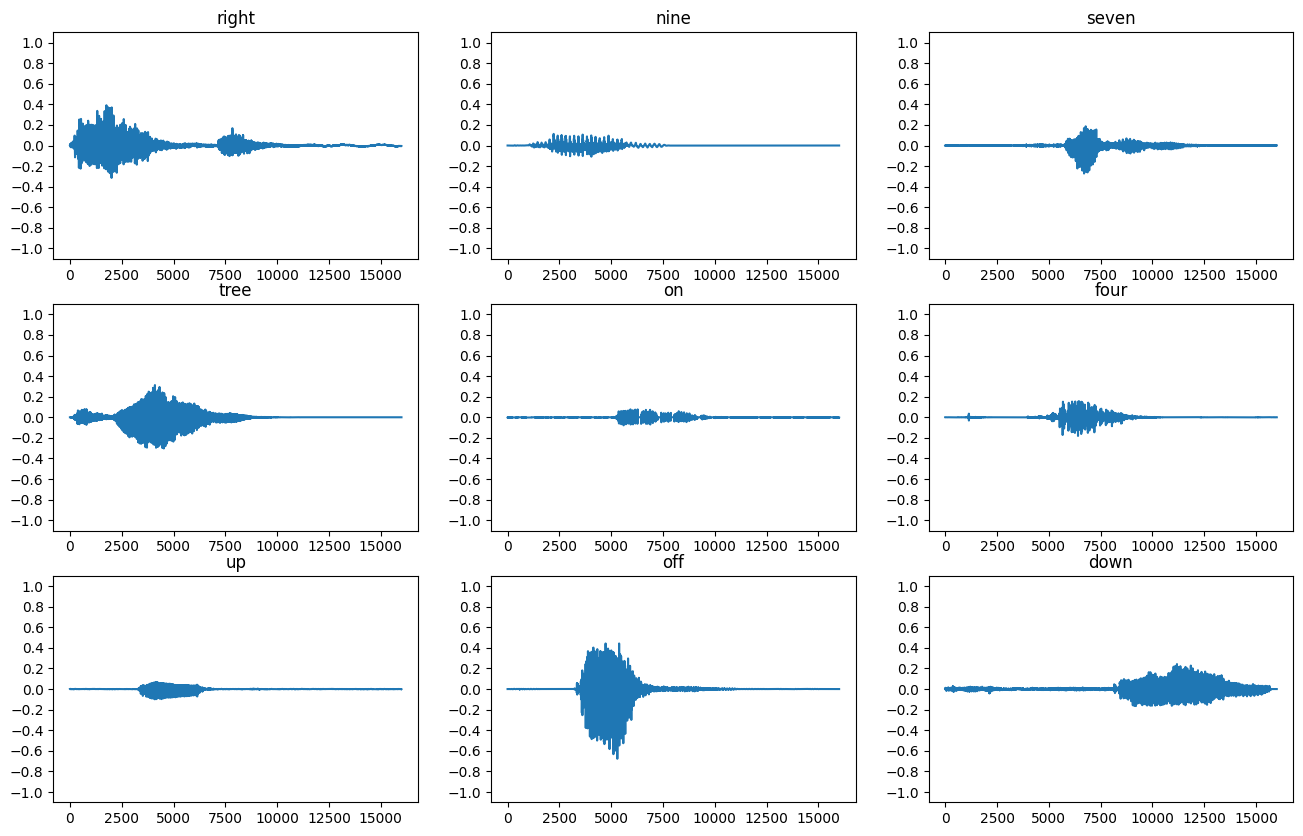

In [19]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [20]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

*Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:*

In [21]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: nine
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: seven
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [22]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

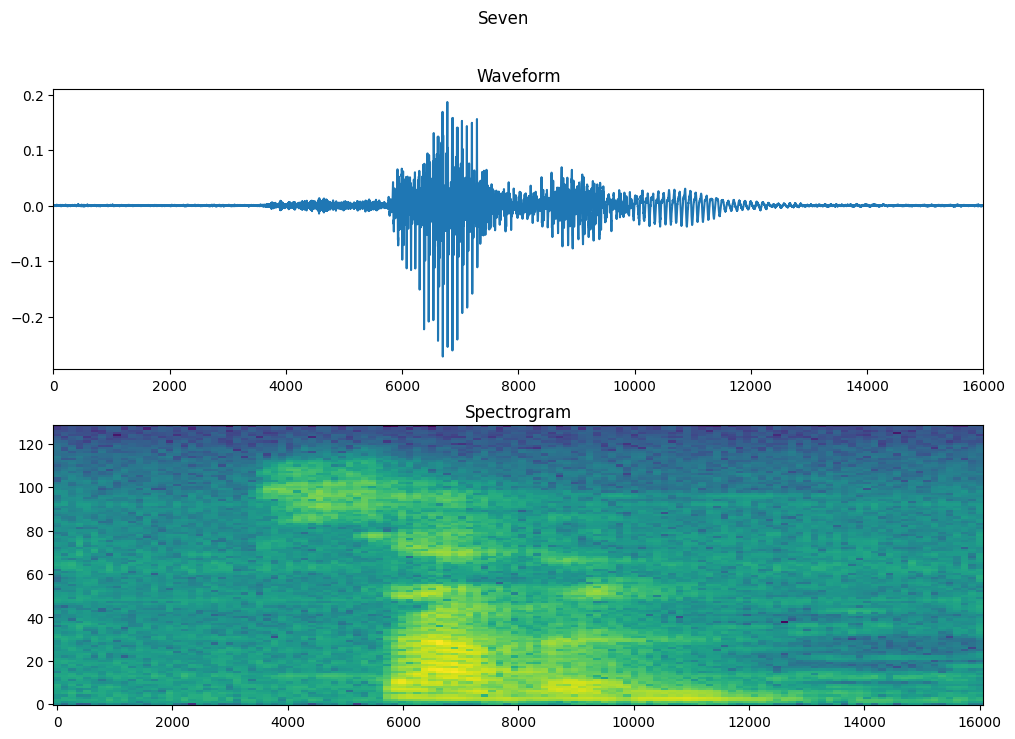

In [23]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

*Now, create spectrogram datasets from the audio datasets:*

In [24]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [25]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [26]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

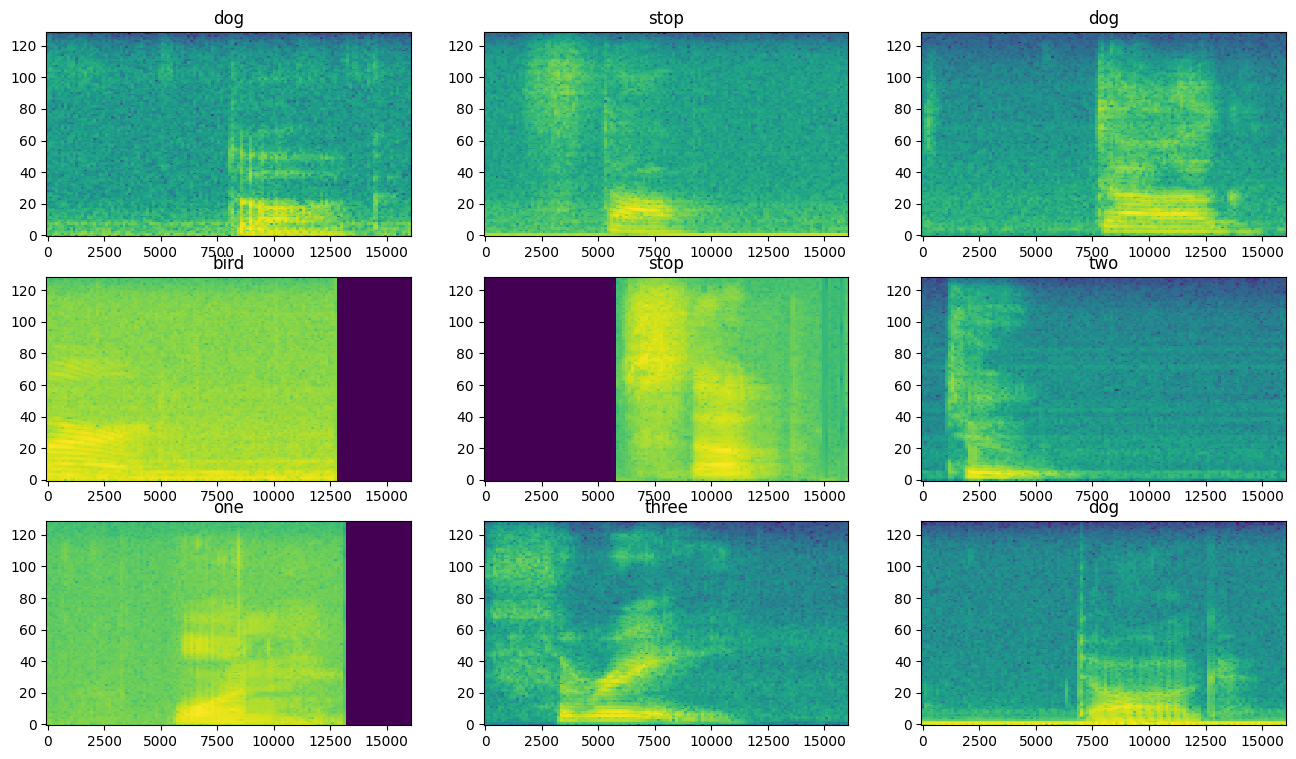

In [27]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [28]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [29]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,628,449 (6.21 MB)

 Trainable params: 1,628,446 (6.21 MB)

 Non-trainable params: 3 (16.00 B)

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [31]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 127s 155ms/step - accuracy: 0.2316 - loss: 2.7000 - val_accuracy: 0.6798 - val_loss: 1.2244
Epoch 2/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 129s 139ms/step - accuracy: 0.5883 - loss: 1.3778 - val_accuracy: 0.7673 - val_loss: 0.8335
Epoch 3/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 112s 139ms/step - accuracy: 0.6814 - loss: 1.0487 - val_accuracy: 0.8009 - val_loss: 0.7008
Epoch 4/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 143s 139ms/step - accuracy: 0.7282 - loss: 0.8903 - val_accuracy: 0.8170 - val_loss: 0.6401
Epoch 5/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 142s 139ms/step - accuracy: 0.7606 - loss: 0.7791 - val_accuracy: 0.8270 - val_loss: 0.5934
Epoch 6/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 146s 144ms/step - accuracy: 0.7812 - loss: 0.7100 - val_accuracy: 0.8402 - val_loss: 0.5462
Epoch 7/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 141s 143ms/step - accuracy: 0.7940 - loss: 0.6655 - val_accuracy: 0.8482 - val_loss: 0.5142
Epoch 8/10
810/810 ━━━━━━━━━━━━━━━━━━━━ 117s 145ms/step - accuracy: 0.8100 -

Text(0, 0.5, 'Accuracy [%]')

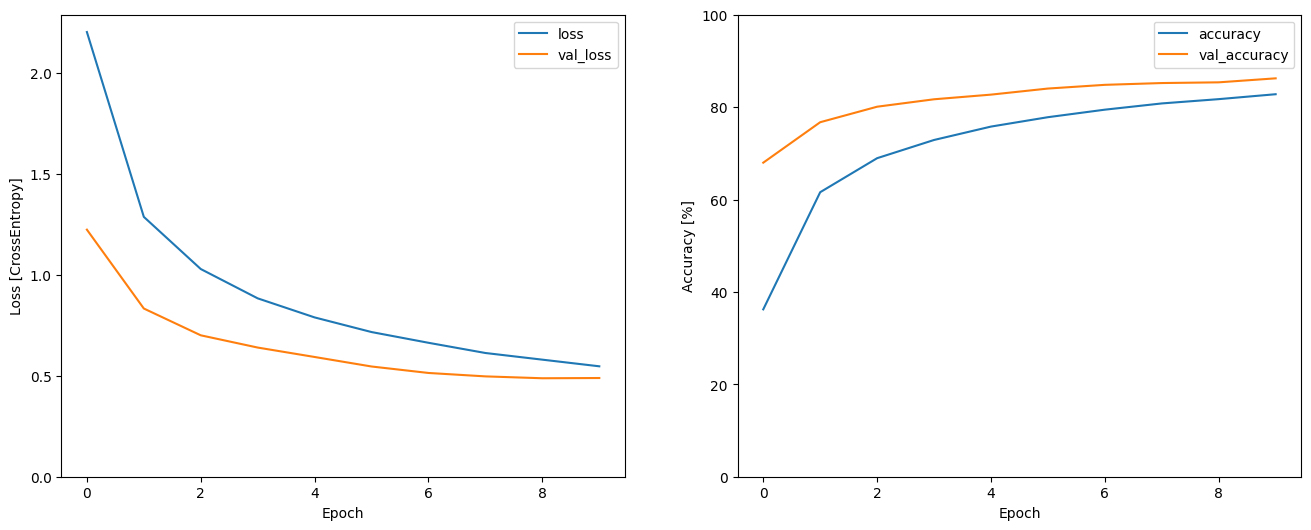

In [32]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [33]:
model.evaluate(test_spectrogram_ds, return_dict=True)

102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.8638 - loss: 0.4719


{'accuracy': 0.8606481552124023, 'loss': 0.48430225253105164}

In [34]:
y_pred = model.predict(test_spectrogram_ds)

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step


In [35]:
y_pred

array([[-22.316628  , -24.899193  , -12.5428915 , ..., -19.806992  ,
        -31.608086  ,   2.532534  ],
       [ -0.20020567,  -6.3806    ,  -1.9634906 , ..., -13.405405  ,
         -7.8443933 ,  -8.676641  ],
       [ -1.5108604 , -16.056427  ,  16.27792   , ..., -13.514834  ,
          3.4618616 , -12.663674  ],
       ...,
       [ -7.071699  , -11.122427  , -12.416618  , ..., -25.68812   ,
        -22.85645   ,   3.7772744 ],
       [ -1.9989294 ,  -6.3827376 ,  -2.642477  , ...,  -8.646166  ,
         -2.3506413 ,   3.7800586 ],
       [ -3.4318876 ,  11.90299   , -13.463045  , ..., -13.34462   ,
        -17.594734  ,  -7.047815  ]], dtype=float32)

In [36]:
y_pred = tf.argmax(y_pred, axis=1)

In [37]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

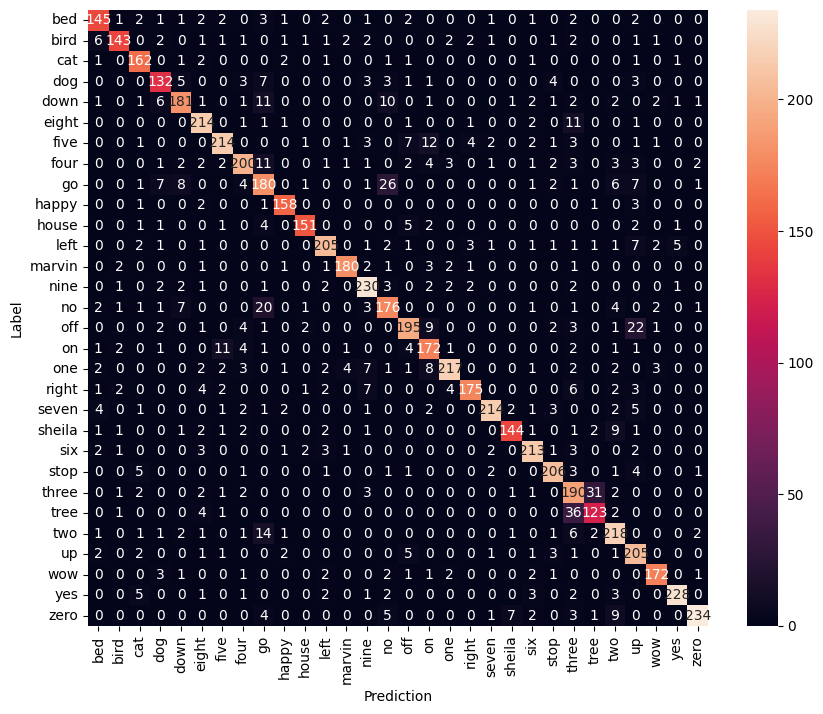

In [38]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

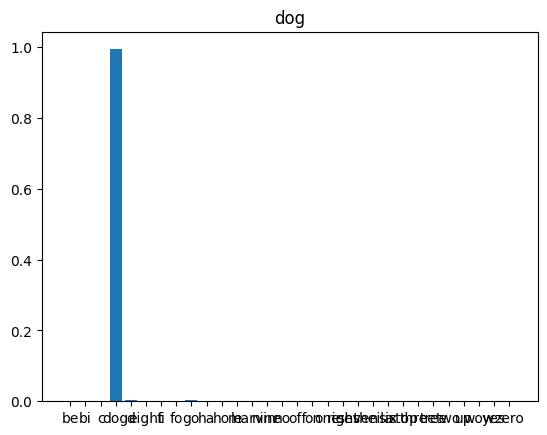

In [45]:
x = '/content/data/speech_commands_v0_extracted/dog/00f0204f_nohash_2.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['be', 'bi', 'c', 'dog', 'd', 'eight', 'fi', 'fo', 'go', 'ha',
    'ho', 'le', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right',
    'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('dog')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [56]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [57]:
export = ExportModel(model)
export(tf.constant(str('/content/data/speech_commands_v0_extracted/dog/00f0204f_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 30), dtype=float32, numpy=
 array([[-4.0968075 , -1.4207902 , -5.101353  ,  7.522821  ,  0.28594488,
         -5.441383  , -1.2376168 , -4.5646367 ,  1.2359252 , -7.2064047 ,
         -1.8426094 , -5.6949596 , -6.9439692 , -2.586689  ,  0.06996492,
         -0.9096241 , -1.1897398 , -7.475602  , -5.725414  , -5.186087  ,
         -8.004058  , -9.0192175 , -0.07620393, -8.867046  , -9.735649  ,
         -5.949838  , -0.6655352 , -3.4781208 , -8.728431  , -8.000122  ]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'dog'], dtype=object)>}

In [58]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

TypeError: this __dict__ descriptor does not support '_DictWrapper' objects